# Classifying ECG data

This data set is publically available in www.timeseriesclassification.com and represents two types of electrocardiogram (ECG) readings: with cardiac event and without.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train=pd.read_csv("./data/ECG/ECG200_TRAIN.txt", header=None, sep='\s+')
test = pd.read_csv("./data/ECG/ECG200_TEST.txt", header=None, sep='\s+')

## Creating a baseline model

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from scipy.signal import savgol_filter

In [4]:
X_train = train.iloc[:,1:].apply(lambda row: savgol_filter(row, 5, 2), axis=0)
X_test = test.iloc[:,1:].apply(lambda row: savgol_filter(row, 5, 2), axis=0)
y_train = train.iloc[:,0]
y_test = test.iloc[:,0]

Note that we have almost the same number of features as training examples! Perhaps we need to remove some of those.

In [5]:
sel=SelectKBest(k=10)
lr=LogisticRegression(random_state=42, solver='lbfgs')
pipe=make_pipeline(sel, lr)

In [6]:
pipe.fit(X_train, y_train);
print('Training score:, ', pipe.score(X_train, y_train));

Training score:,  0.75


In [7]:
print('Holdout score: ', pipe.score(X_test, y_test))

Holdout score:  0.81


## Finding the optimal number of features

We can tune the hyperparameter `k` from `SelectKBest` to determine the number of features.

In [8]:
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

def get_score(k):
    lr=LogisticRegression(solver='lbfgs')
    sel=SelectKBest(k=k)
    pipe=make_pipeline(sel, lr)
    return cross_val_score(pipe, X_train,y_train, cv=5, scoring='accuracy').mean()


ks = np.arange(3, 97)
scores = [get_score(k) for k in tqdm(ks)]

100%|██████████| 94/94 [00:04<00:00, 19.25it/s]


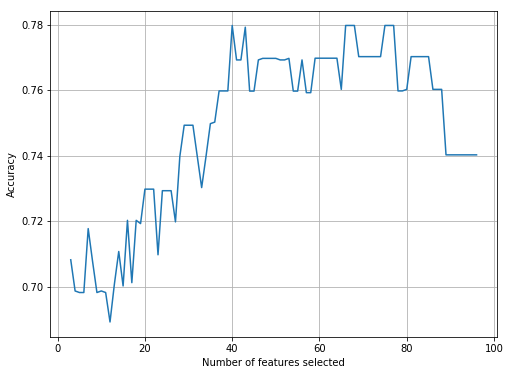

In [9]:
plt.figure(figsize=(8,6))
plt.plot(ks, scores)
plt.xlabel("Number of features selected")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

We see that there is an increase in performance as the number of features increases. The spikes are due to the fact that we have very little data. 

This is taken on the training set, to be more precise we could use instead the cross validation error.

## Final model and feature importance

To understand better our features, let's plot the scores together with two samples of our ECG data.

In [10]:
select_k=SelectKBest(k=40)
select_k.fit(X_train,y_train)

SelectKBest(k=40, score_func=<function f_classif at 0x1218e2268>)

In [11]:
from sklearn.preprocessing import minmax_scale
normalized_scores = minmax_scale(select_k.scores_)

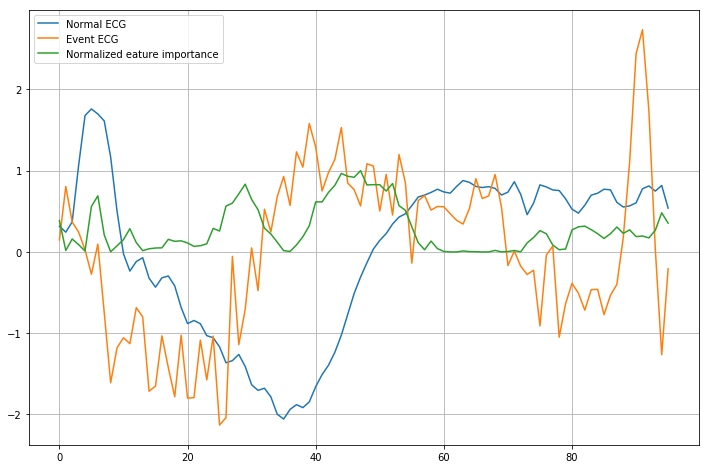

In [13]:
plt.figure(figsize=(12,8))
plt.plot(train.iloc[2,1:].values, label="Normal ECG")
plt.plot(train.iloc[1,1:].values, label="Event ECG")
plt.plot(normalized_scores, label="Normalized eature importance")
plt.legend()
plt.grid()
plt.show()